# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
### Import Libraries

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

%matplotlib inline

## Step 1: Camera Calibration

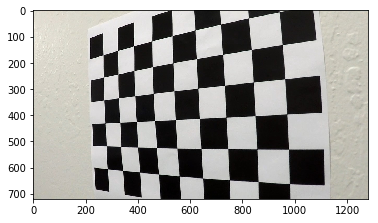

In [2]:
#show example chessboard image
image=mpimg.imread('./camera_cal/calibration4.jpg')
plt.imshow(image)

In [3]:
# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

#Array of chessboard images with corners identified
Images_with_Corners=[]

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        Images_with_Corners.append(img)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)        

cv2.destroyAllWindows()

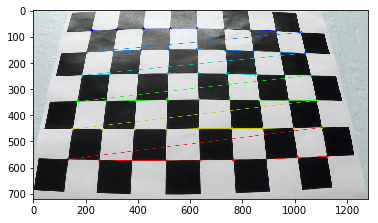

In [4]:
#show example chessboard image with corners
plt.imshow(Images_with_Corners[12])

In [5]:
#calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#save variable on computer through pickle
camera_calibration_values = {'ret': ret, 'mtx': mtx, 'dist': dist, 'rvecs': rvecs, 'tvecs': tvecs} 
if ret:
    with open("cal_coeff.p", 'wb') as file: 
        pickle.dump(camera_calibration_values, file, protocol=pickle.HIGHEST_PROTOCOL)

### Image Read

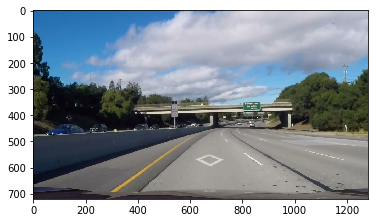

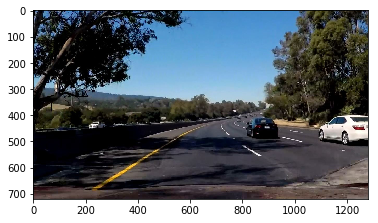

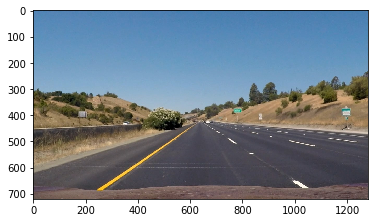

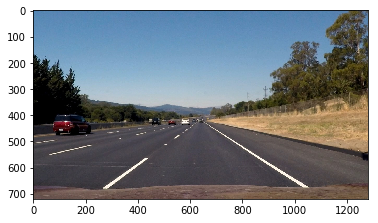

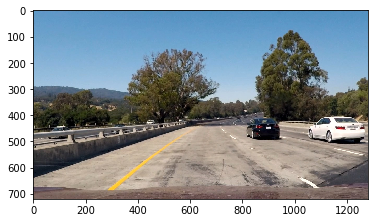

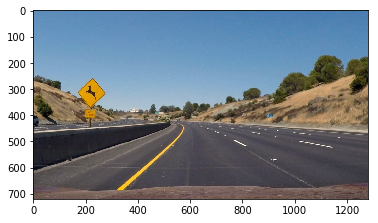

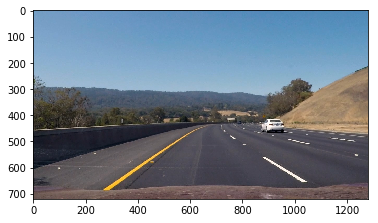

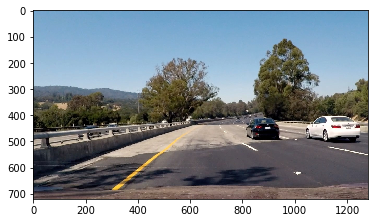

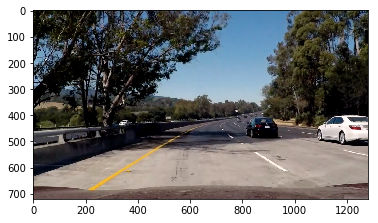

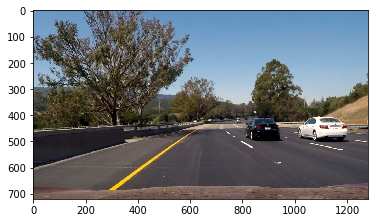

In [60]:
#read all filenames in test_images folder
test_image_names = glob.glob('./test_images/*.jpg')
test_images = []

#read images from filenames and convert to RGB from BGR
for fname in test_image_names:
    test_images.append(cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB))

for im in test_images:
    fig=plt.figure()
    plt.imshow(im)

## Step 2: Distortion Correction

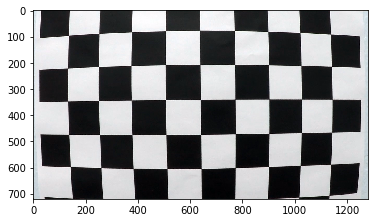

In [61]:
#display example chessboard image
chess_image=cv2.imread(images[0])
plt.imshow(chess_image)

In [62]:
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

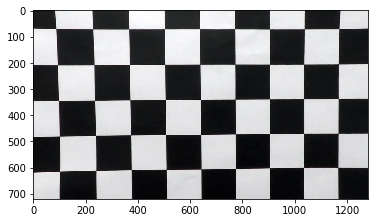

In [63]:
#display undistorted chessboard image
plt.imshow(undistort(chess_image))

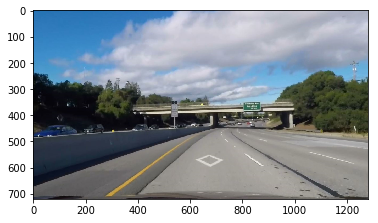

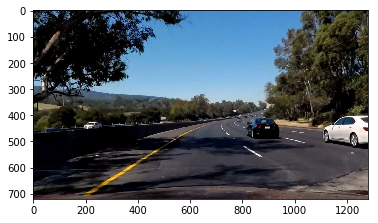

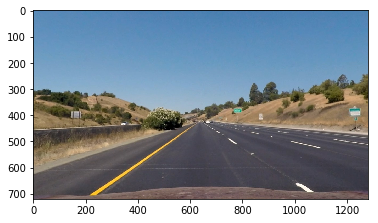

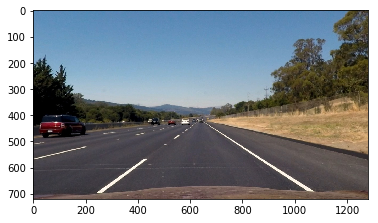

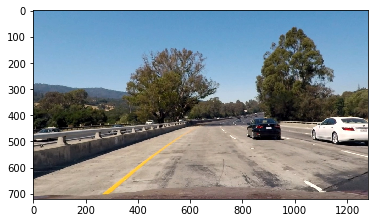

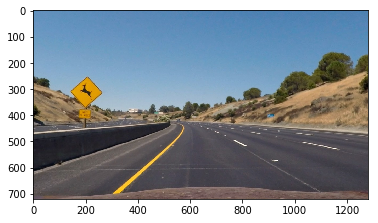

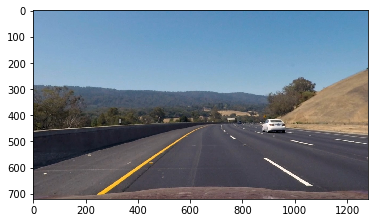

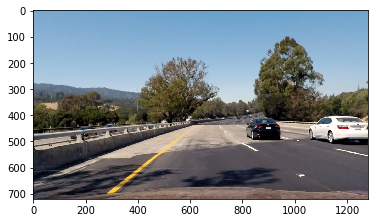

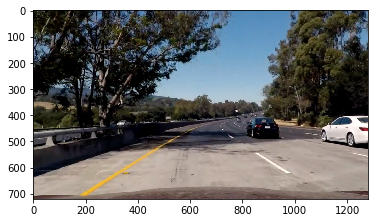

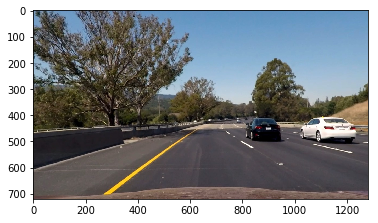

In [64]:
#undistort all test_images
undistorted_images = []
for im in test_images:
    undistorted_images.append(undistort(im))

for im in undistorted_images:
    plt.figure()
    plt.imshow(im)

## Step 3: Gradient and Color Transform

In [65]:
def hls_transform(img, s_thresh, l_thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat = hls[:,:,2]
    lig = hls[:,:,1]
    binary = np.zeros_like(sat)
    #(sat > s_thresh[0]) & (sat <= s_thresh[1]) & 
    binary[(sat > s_thresh[0]) & (sat <= s_thresh[1]) & (lig > l_thresh[0]) & (lig <= l_thresh[1])] = 1
    return binary

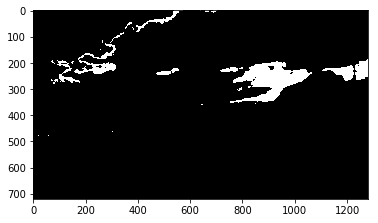

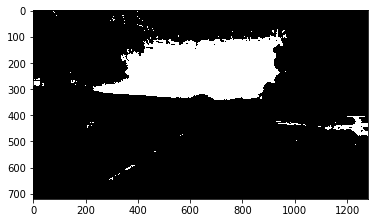

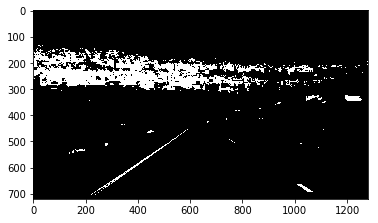

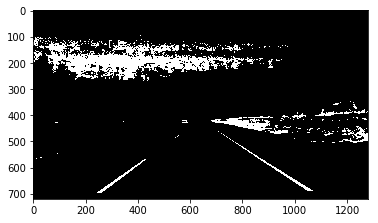

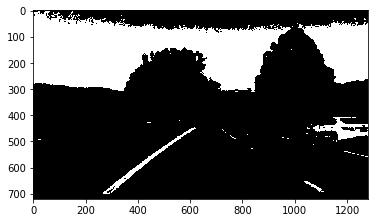

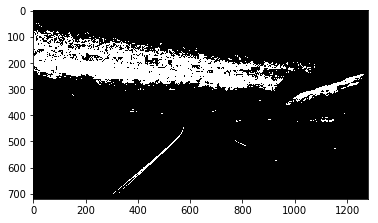

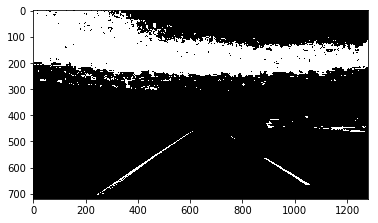

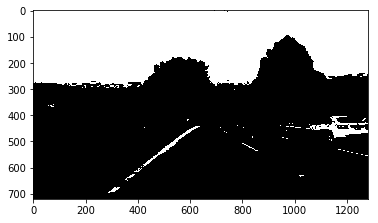

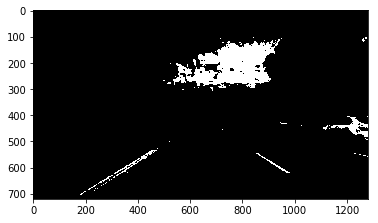

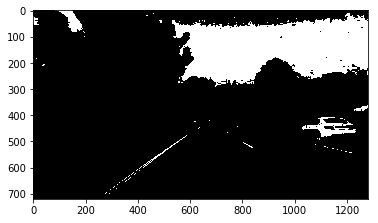

In [66]:
#do HLS transform and keep saturation data within threshold for all the test images
hls = []
for im in undistorted_images:
    hls.append(hls_transform(im, (100,255), (150,255)))

for im in hls:
    plt.figure()
    plt.imshow(im, cmap='gray')

In [67]:
def abs_grad(img, sobel_kernel, thresh, orient):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def mag_grad(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary = np.zeros_like(gradmag)
    binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary

def dir_grad(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    graddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary = np.zeros_like(graddir)
    binary[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return binary

In [68]:
def combined_gradient(img, ksize):
    gradx = abs_grad(img, sobel_kernel=ksize, thresh=(100, 255), orient='x')
    grady = abs_grad(img, sobel_kernel=ksize, thresh=(100, 255), orient='y')
    mag_binary = mag_grad(img, sobel_kernel=ksize, thresh=(100, 255))
    dir_binary = dir_grad(img, sobel_kernel=ksize, thresh=(np.pi/4, np.pi/2))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

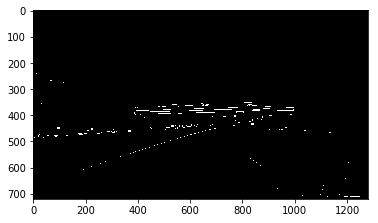

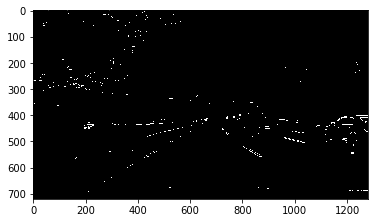

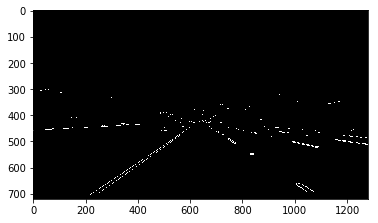

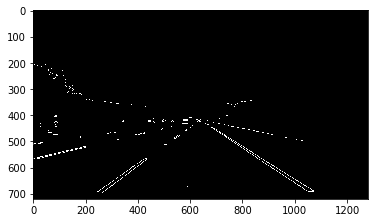

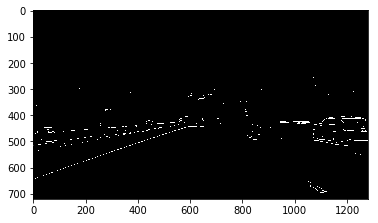

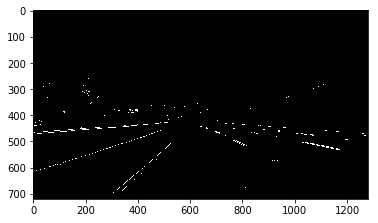

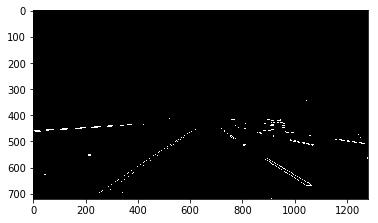

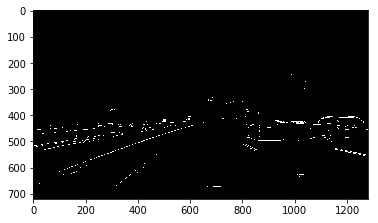

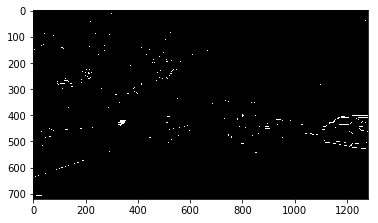

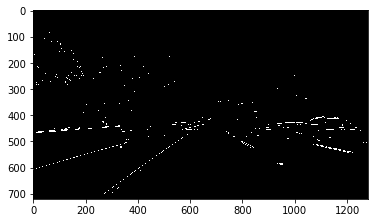

In [69]:
#combined gradient transform
grad = []
for im in undistorted_images:
    grad.append(combined_gradient(im, 3))

for im in grad:
    plt.figure()
    plt.imshow(im, cmap='gray')

(720, 1280)


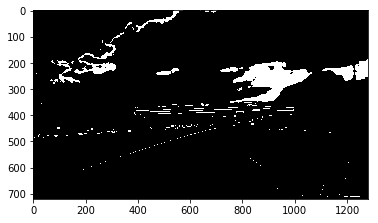

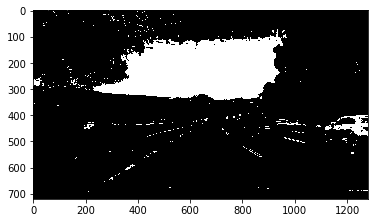

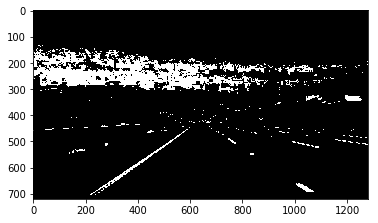

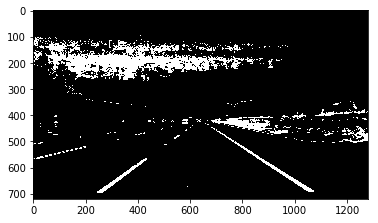

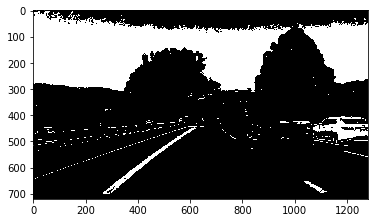

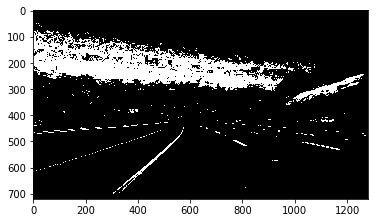

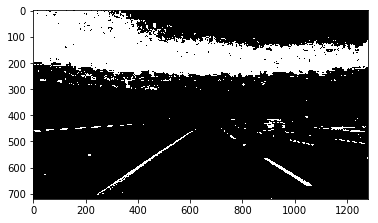

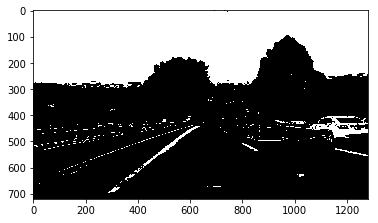

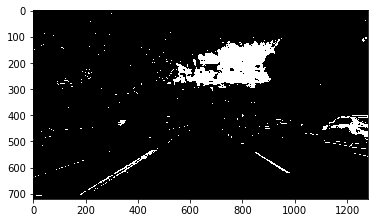

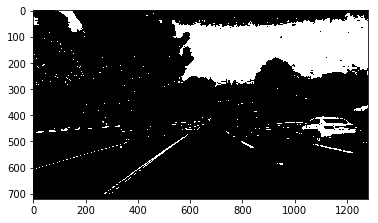

In [70]:
#combining gradient and HLS transform output
mixed = np.zeros_like(grad)
print(mixed[0].shape)
for i in range(len(mixed)):
    mixed[i]=(grad[i] == 1) | (hls[i] == 1)

for im in mixed:
    plt.figure()
    plt.imshow(im, cmap='gray')

## Step 4: Perspective Transform

In [71]:
def pers_trans(img, src, dst):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

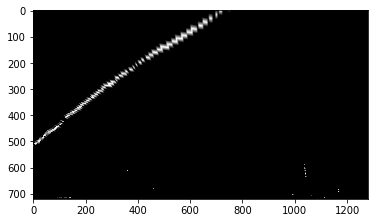

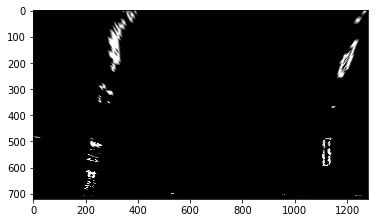

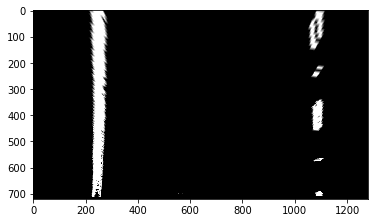

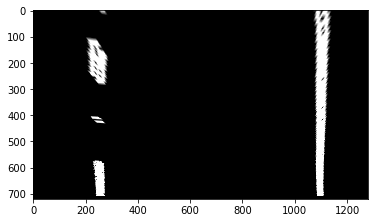

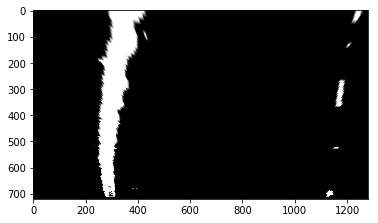

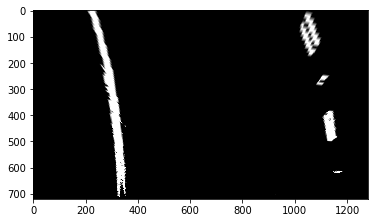

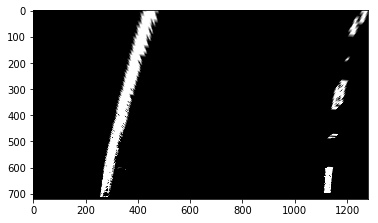

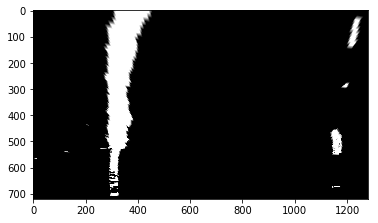

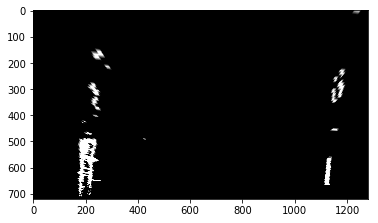

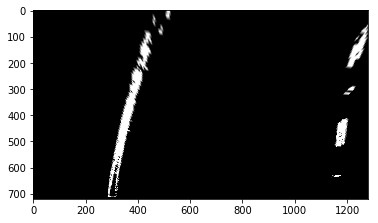

In [72]:

img_size = (undistorted_images[0].shape[1], undistorted_images[0].shape[0])

#src is the portion of road where we want to find lane lines
src = np.float32([[np.int(img_size[0]*0.435), np.int(img_size[1]*0.65)],
                  [np.int(img_size[0]*0.565), np.int(img_size[1]*0.65)],
                  [np.int(img_size[0]*0.9), img_size[1]],
                  [np.int(img_size[0]*0.1), img_size[1]]])
offset = 150

#spread road area on complete destination perspective transformed image
dst = np.float32([[offset, 0], 
                  [img_size[0]-offset, offset], 
                  [img_size[0]-offset, img_size[1]], 
                  [offset, img_size[1]]])
warped=[]
for im in mixed:
    warped.append(pers_trans(im,src,dst))

for im in warped:
    plt.figure()
    plt.imshow(im, cmap='gray')

## Step 5: Lane Lines Detection

In [73]:
def histo(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

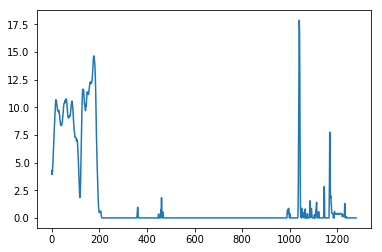

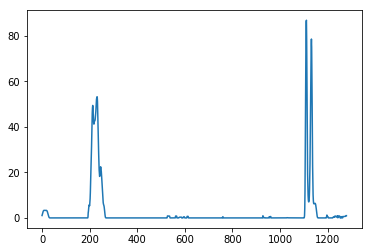

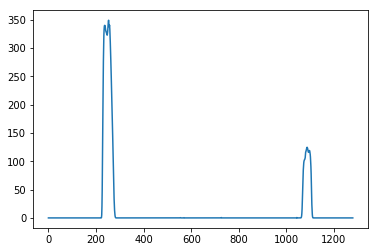

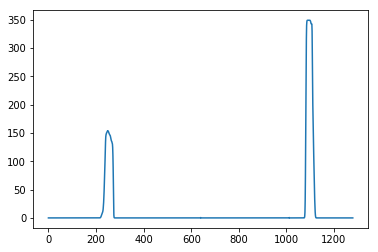

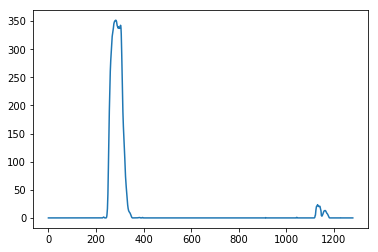

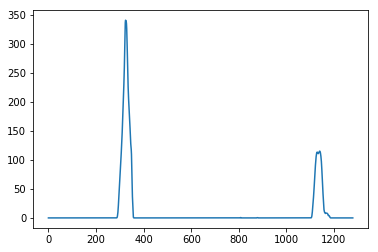

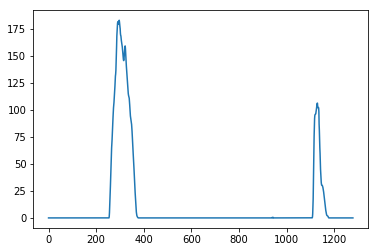

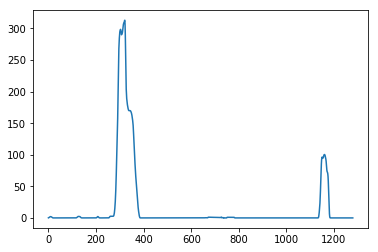

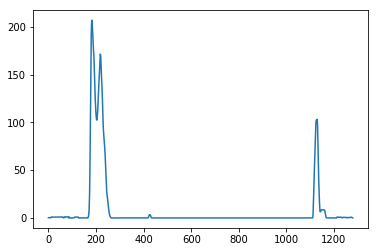

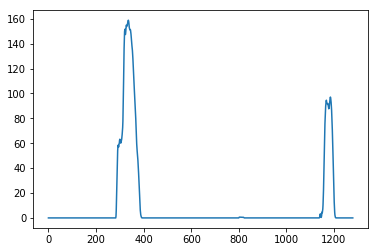

In [74]:
#find lane markings on x-axis using histogram
histogram=[]
for im in warped:
    histogram.append(histo(im))

for his in histogram:
    plt.figure()
    plt.plot(his)

## Step 6: Polynomial Fit

In [75]:
class image_feat():
    def __init__(self):
        self.left_fit = []
        self.right_fit = []
        self.left_fitx = []
        self.right_fitx = []
        self.leftx = []
        self.lefty = []
        self.rightx = []
        self.righty = []
        self.ploty = []
        self.y_eval = []
        self.left_curverad = []
        self.right_curverad = []
        self.pos_from_center = []

In [76]:
images_features = np.ndarray((len(warped),),dtype=np.object)

for i in range(len(images_features)):
    images_features[i] = image_feat()

86.9228389732
1077.75728509
213.128244935
1106.5551748
241.158348552
1097.01982709
255.998873205
1094.02281948
286.743881229
1135.08222059
337.107402489
1187.00276934
268.443757995
1124.80182315
320.207312513
1156.61450813
190.752784782
1123.90212545
300.697537465
1165.5800268


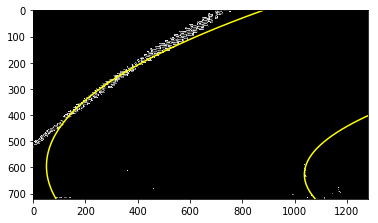

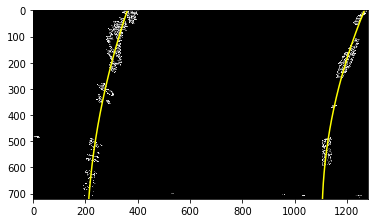

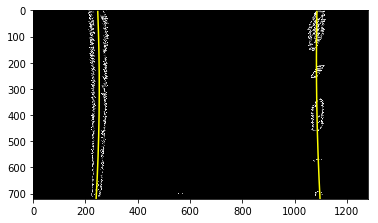

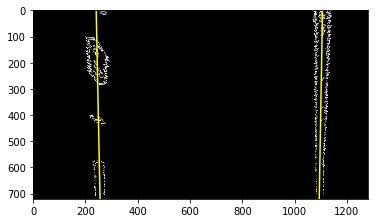

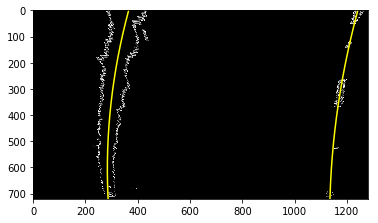

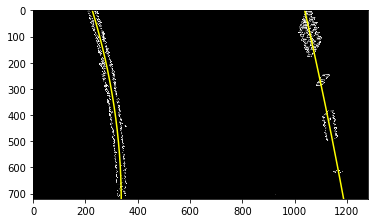

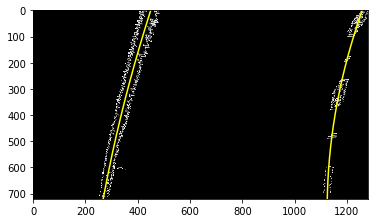

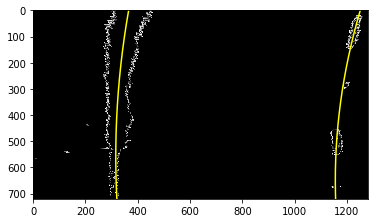

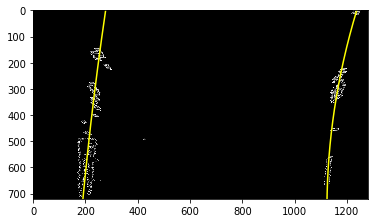

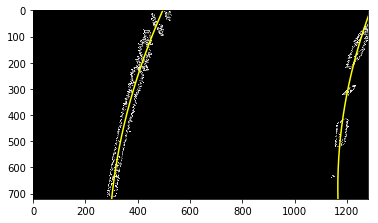

In [77]:
for im, his, im_feat in zip(warped,histogram,images_features):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((im, im, im))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(his.shape[0]/2)
    leftx_base = np.argmax(his[:midpoint])
    rightx_base = np.argmax(his[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(im.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = im.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    plt.figure()
    plt.imshow(out_img)
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = im.shape[0] - (window+1)*window_height
        win_y_high = im.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 10) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 10) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    im_feat.leftx = nonzerox[left_lane_inds]
    im_feat.lefty = nonzeroy[left_lane_inds] 
    im_feat.rightx = nonzerox[right_lane_inds]
    im_feat.righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    im_feat.left_fit = np.polyfit(im_feat.lefty, im_feat.leftx, 2)
    im_feat.right_fit = np.polyfit(im_feat.righty, im_feat.rightx, 2)

    # Generate x and y values for plotting
    im_feat.ploty = np.linspace(0, im.shape[0]-1, im.shape[0] )
    im_feat.left_fitx = im_feat.left_fit[0]*im_feat.ploty**2 + im_feat.left_fit[1]*im_feat.ploty + im_feat.left_fit[2]
    im_feat.right_fitx = im_feat.right_fit[0]*im_feat.ploty**2 + im_feat.right_fit[1]*im_feat.ploty + im_feat.right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    print(im_feat.left_fitx[-1])
    print(im_feat.right_fitx[-1])
    plt.plot(im_feat.left_fitx, im_feat.ploty, color='yellow')
    plt.plot(im_feat.right_fitx, im_feat.ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


## Step 7: Lane Curvature

In [78]:
for im_feat in images_features:    
    im_feat.y_eval = np.max(im_feat.ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    lane_center = 640
    #distance of right lane marking from center
    right_distance = im_feat.right_fitx[-1]-lane_center
    #distance of left lane marking from center
    left_distance = lane_center - im_feat.left_fitx[-1]
    #position of center of car from center of lane in meters
    im_feat.pos_from_center = np.absolute(right_distance - left_distance)*xm_per_pix
    print(round(im_feat.pos_from_center, 3))
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(im_feat.lefty*ym_per_pix, im_feat.leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(im_feat.righty*ym_per_pix, im_feat.rightx*xm_per_pix, 2)
    
    left_lane_pos = left_fit_cr[0]*(719)**2 + left_fit_cr[1]*(719) + left_fit_cr[2]
    right_lane_pos = right_fit_cr[0]*(719)**2 + right_fit_cr[1]*(719) + right_fit_cr[2]
    
    # Calculate the new radii of curvature
    im_feat.left_curverad = ((1 + (2*left_fit_cr[0]*im_feat.y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    im_feat.right_curverad = ((1 + (2*right_fit_cr[0]*im_feat.y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(im_feat.left_curverad, 'm', im_feat.right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

0.61
70.9244098209 m 34.8314433741 m
0.21
898.537778098 m 636.486357581 m
0.308
2481.46513243 m 3296.61472176 m
0.37
3856572.22035 m 540573.735166 m
0.75
743.998818781 m 984.899261052 m
1.29
792.197542742 m 5359.80988286 m
0.599
1747.77406054 m 708.260005324 m
1.04
1042.60110789 m 726.864586422 m
0.183
4525.03246947 m 828.051984226 m
0.985
697.045952078 m 605.105321396 m


## Step 8: Lane Boundaries Overlay on Original Image

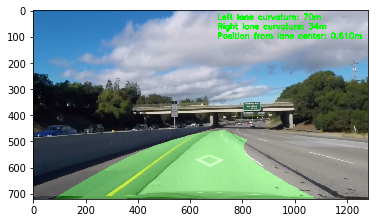

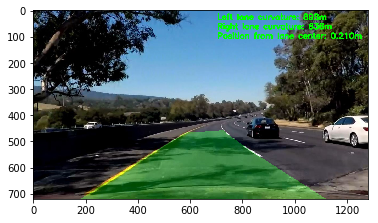

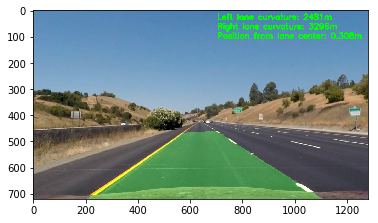

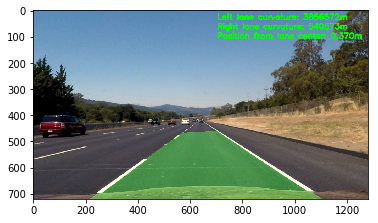

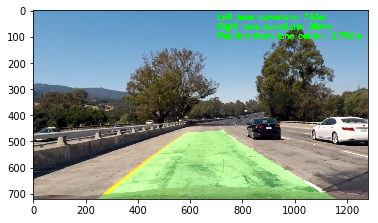

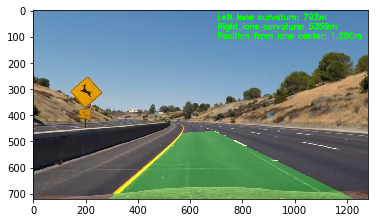

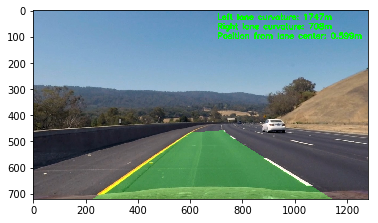

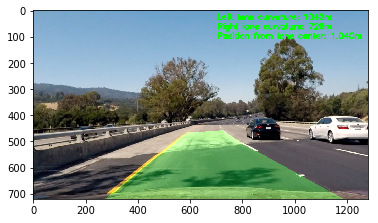

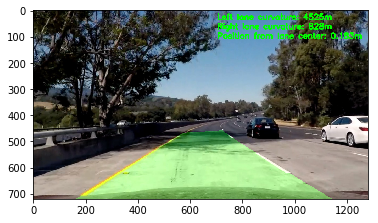

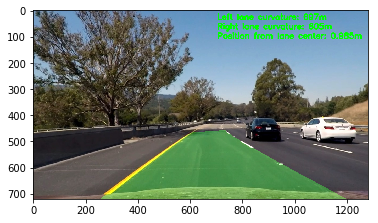

In [79]:
overlayed_images = []
font = cv2.FONT_HERSHEY_SIMPLEX
for im_feat, text_im in zip(images_features, undistorted_images):    
    #collecting points from left and right lanes to use as boundaries of highlighted lane
    pts_left = np.array([np.transpose(np.vstack([im_feat.left_fitx, im_feat.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([im_feat.right_fitx, im_feat.ploty])))])
    pts = np.hstack((pts_left, pts_right))
    fitted_lane_image = np.zeros_like(warped[0])
    # Draw the lane onto the warped blank image
    cv2.fillPoly(fitted_lane_image, np.int_([pts]), 1)
    #do perspective transform to overlay the lanes back on to road
    unwarp = pers_trans(fitted_lane_image, dst, src)

    lanes=np.zeros_like(text_im)
    #color them to green
    lanes[(unwarp>0)]=(0,255,0)
    
    #add test image and detected lane
    overlayed_images.append(cv2.addWeighted(text_im, 1, lanes, 0.3, 0))

#add text on images 
for im, im_feat in zip(overlayed_images,images_features):
    left_text = 'Left lane curvature: %dm' %im_feat.left_curverad
    right_text = 'Right lane curvature: %dm' %im_feat.right_curverad
    pos_text = 'Position from lane center: %.3fm'%im_feat.pos_from_center
    cv2.putText(im, left_text, (np.int(text_im.shape[1]*0.55),np.int(text_im.shape[0]*0.05)), font, 1, (0,255,0), 4, cv2.LINE_AA)
    cv2.putText(im, right_text, (np.int(text_im.shape[1]*0.55),np.int(text_im.shape[0]*0.1)), font, 1, (0,255,0), 4, cv2.LINE_AA)
    cv2.putText(im, pos_text, (np.int(text_im.shape[1]*0.55),np.int(text_im.shape[0]*0.15)), font, 1, (0,255,0), 4, cv2.LINE_AA)
    plt.figure()
    plt.imshow(im, cmap = 'Greys_r')